# Movie Sentiment Analysis with LLMs


In this demo, we show how to use a pre-trained encoder for a simple downstream task.  As an example we look at sentiment analysis using movie reviews from the IMDB dataset (sourced from Kaggle). We begin by encoding each review into a dense vector using a pre-trained sentence transformer, capturing semantic meaning beyond simple word counts. These embeddings are then fed into a simple neural network to predict whether a review expresses positive or negative sentiment. While the model is not state-of-the-art, it serves as a clean and interpretable example of how modern NLP pipelines combine pre-trained language models with downstream classifiers

## GPU Setting

For this demo, you will want access to a GPU, at least the free tier T4 GPU available on Google Colab.



## Downloading the Data

The IMDB sentiment dataset used in this notebook was originally introduced by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts in their 2011 paper [**Learning Word Vectors for Sentiment Analysis**](https://aclanthology.org/P11-1015.pdf). It contains 50,000 movie reviews labeled as positive or negative, carefully curated to balance sentiment and avoid overlap between training and test sets. This dataset was a landmark contribution to NLP, providing a clean benchmark for evaluating text classification models and helping catalyze research in sentiment-aware embeddings and deep learning for language understanding.

Today, you can download their data from several sources including [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).


In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


We can read it as a CSV file.

In [2]:
import os
import pandas as pd
pd = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))
pd.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Now we convert the reviews to a  list of strings and the sentiments to 0-1 vector.  We display an example review.

In [3]:
reviews = pd['review'].tolist()
sentiments = pd['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).tolist()

# Select a random review
ind = 10

# Using textwrap for better printing of long reviews
import textwrap
wrapped_review = textwrap.fill(reviews[ind], width=80) # Wrap at 80 characters

print(f"Reviews {ind}:\n{wrapped_review}\n")
print(f"Sentiments:\n{sentiments[ind]}")

Reviews 10:
Phil the Alien is one of those quirky films where the humour is based around the
oddness of everything rather than actual punchlines.<br /><br />At first it was
very odd and pretty funny but as the movie progressed I didn't find the jokes or
oddness funny anymore.<br /><br />Its a low budget film (thats never a problem
in itself), there were some pretty interesting characters, but eventually I just
lost interest.<br /><br />I imagine this film would appeal to a stoner who is
currently partaking.<br /><br />For something similar but better try "Brother
from another planet"

Sentiments:
0


## Downloading the MiniLM model from Hugging Face

In this demo, we will use Microsoft's excellent [MiniLM model](https://github.com/microsoft/unilm/blob/master/minilm/README.md).  The MiniLM is a remarkably small model that you can run without a powerful GPU and still get decent performance.  For example, you can run the model on Google colab, even with a CPU only.    The MiniLM model is available on [Hugging Face](https://huggingface.co/).  Hugging Face is a widely-used online platform that provides tools and resources to help people build and share AI models, datasets, and applications.  You can use Hugging Face for your projects.  

To use the MiniLM model, we first install the `sentence-transformers` package that is part of [hugging Face](https://huggingface.co/sentence-transformers).


In [4]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Installing sentence-transformers...")
    !pip install -U sentence-transformers
else:
    print("Not running in Google Colab. Skipping installation of sentence-transformers.")

Running in Google Colab. Installing sentence-transformers...


The mdoels in Hugging Face are mostly available in PyTorch, so we need to import `torch` to use them.  This demo will run faster if you enable the GPU.  If you are on Google Colab, you can select the GPU by following these [instructions](https://medium.com/@208r1a6734/how-to-connect-the-gpu-in-google-colab-5ff4cbd4b0a1).  But, if you only have a CPU, don't worry -- the demo will still work.

In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Next, we download a `SentenceTransformer` model.  [Sentence transformers](https://huggingface.co/sentence-transformers) use LLMs to convert short text to an embedding, which is a numerical vector.  That numerical vector can then be the input for some subsequent neural network.  In this case, we download the miniLM sentence transformer.

In [6]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now we can run the model to embed the reviews.  With a CPU, the encoding is too slow.  But, with the T4 GPU, the encoding of all 50000 reviews can be done in about 2 minutes.

In [7]:
review_embeddings = model.encode(reviews, convert_to_tensor=True, show_progress_bar=True)
print(f"Shape of review embeddings: {review_embeddings.shape}")
print(f"First review embedding (partial):\n{review_embeddings[0][:5]}")

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Shape of review embeddings: torch.Size([50000, 384])
First review embedding (partial):
tensor([ 0.0301,  0.0504, -0.0761,  0.0638,  0.0698], device='cuda:0')


## Training a classifier

We can now train a simple classifier to predict the sentiment from the embedding.  First split the data into training a test

In [9]:
from sklearn.model_selection import train_test_split
X_tr, X_ts, y_tr, y_ts = train_test_split(review_embeddings, sentiments, test_size=0.25, random_state=42)

Next, let's create a simple two layer neural network with 50 hidden states.

In [16]:
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Determine input size from the embeddings
input_size = review_embeddings.shape[1]
hidden_size = 200
num_classes = 1 # For binary classification

model_nn = SentimentClassifier(input_size, hidden_size, num_classes).to(device)
print(model_nn)

SentimentClassifier(
  (fc1): Linear(in_features=384, out_features=200, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


We next create the PyTorch `TensorDataset` and `DataLoader` classes for the training and test data.


In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Convert y_tr and y_ts sentiment lists into PyTorch tensors of type torch.float32 and move to device
y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32).to(device).unsqueeze(1)
y_ts_tensor = torch.tensor(y_ts, dtype=torch.float32).to(device).unsqueeze(1)

# 2. Create a TensorDataset for the training data
train_dataset = TensorDataset(X_tr, y_tr_tensor)

# 3. Create a TensorDataset for the test data
test_dataset = TensorDataset(X_ts, y_ts_tensor)

# 4. Instantiate a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# 5. Instantiate a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

print(f"Shape of training sentiments tensor: {y_tr_tensor.shape}")
print(f"Shape of test sentiments tensor: {y_ts_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Shape of training sentiments tensor: torch.Size([37500, 1])
Shape of test sentiments tensor: torch.Size([12500, 1])
Number of training batches: 375
Number of test batches: 125


We set the BCE loss and Adam optimizer.



In [18]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model_nn.parameters(), lr=0.001) # Adam optimizer with a learning rate of 0.001

# Define training parameters
num_epochs = 10

print("Training parameters defined:")
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Number of Epochs: {num_epochs}")

Training parameters defined:
Loss Function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Number of Epochs: 10


We run with a stnadard training loop.


In [19]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model_nn.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_samples += inputs.size(0)

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation Phase
    model_nn.eval()
    total_test_loss = 0
    correct_test_predictions = 0
    total_test_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model_nn(inputs)
            loss = criterion(outputs, labels)

            total_test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct_test_predictions += (predicted == labels).sum().item()
            total_test_samples += inputs.size(0)

    avg_test_loss = total_test_loss / total_test_samples
    test_accuracy = correct_test_predictions / total_test_samples
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], 'f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, 'f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}')


Epoch [1/10], Train Loss: 0.4657, Train Acc: 0.7841, Test Loss: 0.4125, Test Acc: 0.8084
Epoch [2/10], Train Loss: 0.4095, Train Acc: 0.8106, Test Loss: 0.4014, Test Acc: 0.8187
Epoch [3/10], Train Loss: 0.4005, Train Acc: 0.8159, Test Loss: 0.3956, Test Acc: 0.8219
Epoch [4/10], Train Loss: 0.3928, Train Acc: 0.8214, Test Loss: 0.3917, Test Acc: 0.8225
Epoch [5/10], Train Loss: 0.3863, Train Acc: 0.8243, Test Loss: 0.3898, Test Acc: 0.8214
Epoch [6/10], Train Loss: 0.3789, Train Acc: 0.8290, Test Loss: 0.3864, Test Acc: 0.8242
Epoch [7/10], Train Loss: 0.3715, Train Acc: 0.8330, Test Loss: 0.3822, Test Acc: 0.8254
Epoch [8/10], Train Loss: 0.3643, Train Acc: 0.8384, Test Loss: 0.3786, Test Acc: 0.8278
Epoch [9/10], Train Loss: 0.3560, Train Acc: 0.8414, Test Loss: 0.3801, Test Acc: 0.8268
Epoch [10/10], Train Loss: 0.3490, Train Acc: 0.8451, Test Loss: 0.3755, Test Acc: 0.8278


We see that we can eventually obtain about 82% accuracy.  The result is not the state-of-the-art, but we are using a simple LLM with a simple network.  But, the method illustrates how complex text analysis can be performed easily with LLMs as embeddings.


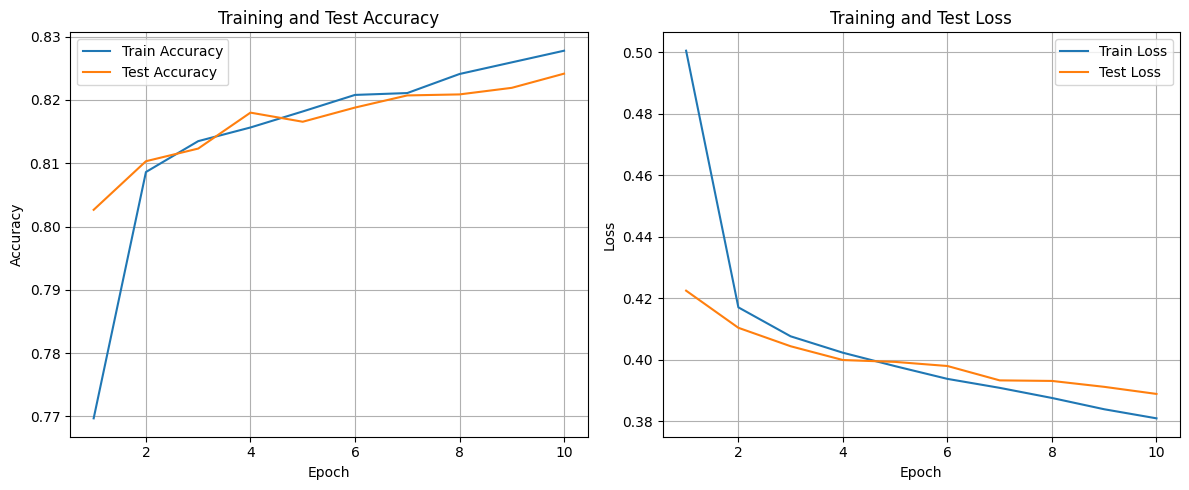

In [15]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()